In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

To be able to use BigQuery you need to gain authentication (see https://cloud.google.com/bigquery/docs/reference/libraries#client-libraries-install-python)

To gain authorization, run this line and restart the notebook:<br>
export GOOGLE_APPLICATION_CREDENTIALS="/Users/dariuscognac/Desktop/My First Project-5da946f4eaaa.json"

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from google.cloud import bigquery
client = bigquery.Client()

In [3]:
def formatNumber(number): 
    return ("{:,}".format(number)) 

#### Latest block (from BigQuery)

In [4]:
query = ("""
SELECT MAX(timestamp)
FROM `bigquery-public-data.bitcoin_blockchain.transactions`
""")

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

unixTime = query_job.to_dataframe().values[0][0]
print(pd.to_datetime(unixTime,unit='ms'))

2018-09-10 13:23:25


#### Current block height

In [5]:
query = ("""
SELECT COUNT(DISTINCT(block_id))
FROM `bigquery-public-data.bitcoin_blockchain.transactions`
""")

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

print(formatNumber(query_job.to_dataframe().values[0][0]))

540,584


#### The current total number of Bitcoin transactions:

In [6]:
query = ("""
SELECT COUNT(*)
FROM `bigquery-public-data.bitcoin_blockchain.transactions`
""")
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

print(formatNumber(query_job.to_dataframe().values[0][0]))

340,311,544


#### The total current number of unique public keys:

In [7]:
query = ("""
SELECT 
    COUNT(DISTINCT(o.output_pubkey_base58))
FROM `bigquery-public-data.bitcoin_blockchain.transactions`
    JOIN UNNEST (outputs) AS o
""")

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

print(formatNumber(query_job.to_dataframe().values[0][0]))

422,814,403


#### Transactions per block

In [8]:
query = ("""
SELECT COUNT(DISTINCT(transaction_id)) AS txs, timestamp 
FROM `bigquery-public-data.bitcoin_blockchain.transactions`
GROUP BY timestamp
ORDER BY timestamp
""")

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

df = query_job.to_dataframe()

In [9]:
# # Round to nearest month
# df["date"] = pd.to_datetime(df.timestamp, unit = 'ms').dt.to_period('M').dt.to_timestamp()

# Round to nearest day
df["date"] = pd.to_datetime(df.timestamp, unit = 'ms').dt.to_period('d').dt.to_timestamp()

,txs,timestamp,date
0,1,1231469665000,2009-01-09
1,1,1231469744000,2009-01-09
2,1,1231470173000,2009-01-09
3,1,1231470988000,2009-01-09
4,1,1231471428000,2009-01-09


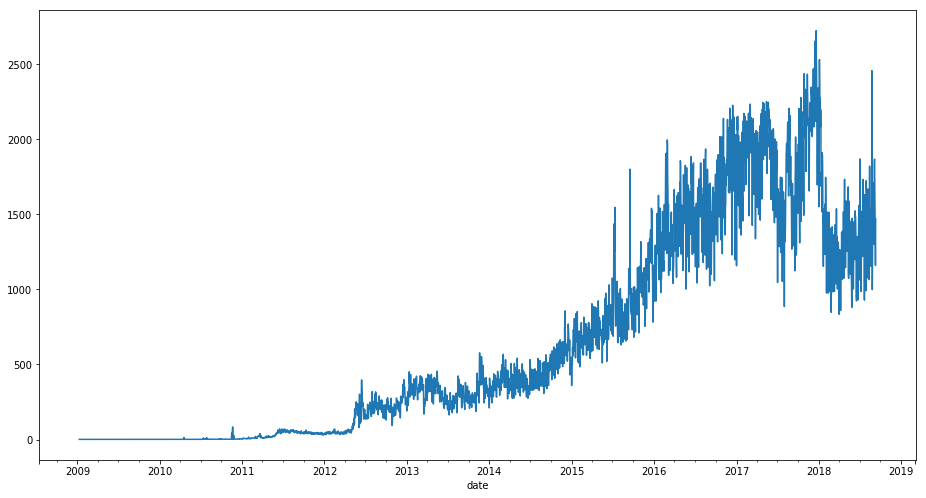

In [10]:
a4_dims = (15.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
df['txs'].groupby(df['date']).mean().plot();

#### Distribution of pubkey usage

In [11]:
query = (
    """SELECT pub_key, unique_receive_txs, unique_sent_txs, (unique_sent_txs/unique_receive_txs) AS ratio_sent
FROM (
  # Subquery number of unique tx per OUTPUT address. This is equivalent to how many times an address RECEIVED a tx
  SELECT
      o.output_pubkey_base58 AS pub_key, COUNT(DISTINCT(transaction_id)) AS unique_receive_txs
  FROM `bigquery-public-data.bitcoin_blockchain.transactions`
      JOIN UNNEST (outputs) AS o
  WHERE o.output_pubkey_base58 IS NOT NULL
  AND timestamp < 1293840000000  # Before 2011 Jan 01
  GROUP BY o.output_pubkey_base58
  )
FULL JOIN (  
  # Subquery number of unique tx per INPUT address. This is equivalent to how many times an address SENT a tx
  SELECT
      i.input_pubkey_base58 AS pub_key, COUNT(DISTINCT(transaction_id)) AS unique_sent_txs
  FROM `bigquery-public-data.bitcoin_blockchain.transactions`
      JOIN UNNEST (inputs) AS i
  WHERE i.input_pubkey_base58 IS NOT NULL
  AND timestamp < 1293840000000  # Before 2011 Jan 01
  GROUP BY i.input_pubkey_base58
  )
  USING(pub_key)
  
-- WHERE unique_receive_txs < 1000 
--   AND unique_sent_txs < 1000
--   AND (unique_receive_txs > 1 OR unique_sent_txs > 1)
-- ORDER BY RAND() LIMIT 1000000"""
)
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query


In [12]:
df = query_job.to_dataframe()
df = df.fillna(0) #NaN corresponds to addresses which have not sent a tx
print(formatNumber(len(df)))
display(df.head())
display(df.describe())

73,531


,pub_key,unique_receive_txs,unique_sent_txs,ratio_sent
0,17yhRAYKJvVmBh14HMxYRHp2Z4erWgk1ne,4007.0,4006.0,0.999750
1,1Bw1hpkUrTKRmrwJBGdZTenoFeX63zrq33,5498.0,5498.0,1.000000
2,14QGCuhKbNAsdeZADZnSmPhEPkzJ5tLvGD,15.0,6.0,0.400000
3,1nHBbVFepCvvuVcVp9NVpRJgSH4ycjNxP,464.0,62.0,0.133621
4,1Q183Tg192FSAKhNfAk5tNFmSchpTRqPdf,78.0,50.0,0.641026


,unique_receive_txs,unique_sent_txs,ratio_sent
count,73531.000000,73531.000000,73531.000000
mean,2.224191,2.983422,0.821610
std,55.285115,373.590622,0.376121
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000
max,5498.000000,100407.000000,1.000000


In [13]:
pd_crosstab_small = pd.crosstab(df["unique_receive_txs"][df["unique_receive_txs"]<6], \
                                df["unique_sent_txs"][df["unique_sent_txs"]<6],\
                                normalize='all')

In [14]:
pd_crosstab_small.head()

unique_sent_txs,0.0,1.0,2.0,3.0,4.0,5.0
unique_receive_txs,,,,,,
1.0,0.153185,0.787003,0.000000,0.000000,0.000000,0.000000
2.0,0.008779,0.008173,0.019855,0.000000,0.000000,0.000000
3.0,0.002435,0.001802,0.002518,0.008407,0.000000,0.000000
4.0,0.001004,0.000922,0.000592,0.000908,0.001610,0.000000
5.0,0.000523,0.000330,0.000303,0.000330,0.000537,0.000784


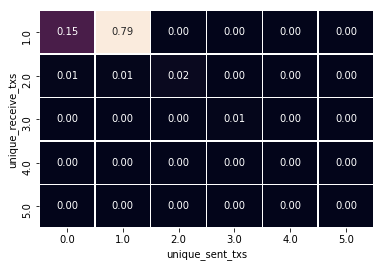

In [17]:
sns.heatmap(pd_crosstab_small, annot=True, cbar=False, fmt='.2f', linewidths=0.3)

In [22]:
pd_crosstab_small = pd.crosstab(df["unique_receive_txs"][df["unique_receive_txs"]>1], \
                                df["unique_sent_txs"][df["unique_sent_txs"]>1],\
                                normalize='all')
pd_crosstab_small.head()

unique_sent_txs,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,...,1747.0,2013.0,3143.0,3712.0,4006.0,4351.0,4966.0,5012.0,5136.0,5498.0
unique_receive_txs,,,,,,,,,,,,,,,,,,,,,
2.0,0.443863,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.056290,0.187942,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.013227,0.020301,0.035989,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.006767,0.007382,0.011996,0.017533,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6.0,0.004306,0.003999,0.005844,0.005844,0.009843,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
